In [1]:
import gym
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

## ActorCritic Network

In [2]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, lr, input_dims, n_actions, fc1_dims=256, fc2_dims=256):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(*input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.pi = nn.Linear(fc2_dims, n_actions)
        self.v = nn.Linear(fc2_dims, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        pi = self.pi(x)
        v = self.v(x)

        return (pi, v)

## Agent-brain 

In [3]:
class Agent():
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions, 
                 gamma=0.99):
        self.gamma = gamma
        self.lr = lr
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.actor_critic = ActorCriticNetwork(lr, input_dims, n_actions, 
                                               fc1_dims, fc2_dims)
        self.log_prob = None

    def choose_action(self, observation):
        state = torch.tensor([observation], dtype=torch.float).to(self.actor_critic.device)
        probabilities, _ = self.actor_critic.forward(state)
        probabilities = F.softmax(probabilities, dim=1)
        action_probs = torch.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)
        self.log_prob = log_prob

        return action.item()

    def train(self, state, reward, state_, done):
        self.actor_critic.optimizer.zero_grad()
        
        '''
        
        Converting to Pytorch Tensors
        
        '''
        
        state = torch.tensor([state], dtype=torch.float).to(self.actor_critic.device)
        state_ = torch.tensor([state_], dtype=torch.float).to(self.actor_critic.device)
        reward = torch.tensor(reward, dtype=torch.float).to(self.actor_critic.device)

        _, critic_value = self.actor_critic.forward(state)
        _, critic_value_ = self.actor_critic.forward(state_)

        delta = reward + self.gamma*critic_value_*(1-int(done)) - critic_value   #Update equation for Actor-Critic

        actor_loss = -self.log_prob*delta               #Actor Loss
        critic_loss = delta**2                          #Critic Loss

        (actor_loss + critic_loss).backward()           #Backpropagate on combined loss
        self.actor_critic.optimizer.step()

## Main Loop for LunarLander-v2

In [4]:
env = gym.make('LunarLander-v2')
agent = Agent(gamma=0.99, lr=0.0005, input_dims=[8], n_actions=4,
              fc1_dims=2048, fc2_dims=1536)

n_games = 1200

scores = []
avg_score=[]
for i in range(n_games):
    done = False
    observation = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.train(observation, reward, observation_, done)
        observation = observation_
    scores.append(score)

    running_avg_score = np.mean(scores[-100:])
        
    avg_score.append(running_avg_score)
    
    print('Episode ', i, 'Score %.1f' % score,
            'Running Average Score %.1f' % running_avg_score)
    

Episode  0 Score -363.7 Running Average Score -363.7
Episode  1 Score -1120.5 Running Average Score -742.1
Episode  2 Score -537.8 Running Average Score -674.0
Episode  3 Score -426.4 Running Average Score -612.1
Episode  4 Score -569.1 Running Average Score -603.5
Episode  5 Score -488.7 Running Average Score -584.4
Episode  6 Score -859.5 Running Average Score -623.7
Episode  7 Score -1037.6 Running Average Score -675.4
Episode  8 Score -766.9 Running Average Score -685.6
Episode  9 Score -454.3 Running Average Score -662.5
Episode  10 Score -571.9 Running Average Score -654.2
Episode  11 Score -782.8 Running Average Score -664.9
Episode  12 Score -347.8 Running Average Score -640.5
Episode  13 Score -771.2 Running Average Score -649.9
Episode  14 Score -753.7 Running Average Score -656.8
Episode  15 Score -338.9 Running Average Score -636.9
Episode  16 Score -426.7 Running Average Score -624.6
Episode  17 Score -484.6 Running Average Score -616.8
Episode  18 Score -458.4 Running Ave

In [5]:
len(avg_score)

1200

## Plot Avg. Rewards/Episodes

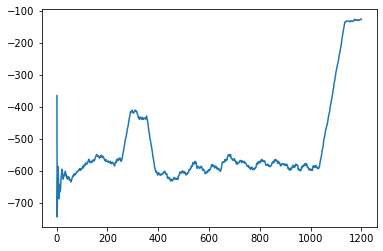

In [6]:
import seaborn as sns
x = [i+1 for i in range(n_games)]
sns.lineplot(x,avg_score)